In [2]:
%connect_info

{
  "shell_port": 50901,
  "iopub_port": 50902,
  "stdin_port": 50903,
  "control_port": 50905,
  "hb_port": 50904,
  "ip": "127.0.0.1",
  "key": "35c129de-cdd3f216e1c6a48b49170558",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f487dc70-917f-4232-bb2c-e58e9ee0a17c.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


## Basic setup

### Import basic Python modules

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from copy import deepcopy
import scipy.interpolate as si

### Directories

In [2]:
DATA_DIR = '/Users/simonameiler/Documents/diazotrophs_biogeography/Data/'
PLOT_DIR = '/Users/simonameiler/Documents/diazotrophs_biogeography/Plots/'

### Load grid from Darwin model

In [3]:
grid = xr.open_dataset(os.path.join(DATA_DIR,'grid.nc'))

lon = grid.X   #needed for plotting
lat = grid.Y    #needed for plotting

area = grid.rA
dz_all = grid.drF

### Load and process Darwin model output

Model data from simulation featuring 5 diazotrophic groups - model run 19_33:

In [4]:
months_vec = range(0,12)
mon_list = ['26160','26400','26640','26880','27120','27360','27600','27840','28080','28320','28560','28800']

diaz1 = np.zeros((len(months_vec),23,160,360)) #smallest diazotroph --> Crocosphaera (UCYN-B)
diaz2 = np.zeros((len(months_vec),23,160,360))
diaz3 = np.zeros((len(months_vec),23,160,360))
diaz4 = np.zeros((len(months_vec),23,160,360))
diaz5 = np.zeros((len(months_vec),23,160,360)) #largest diazotroph --> Trichodesmium

# Open dataset
i = 0
for month in months_vec:
    diaz = xr.open_dataset('/Users/simonameiler/Documents/diazotrophs_biogeography/Data/run19_33_MONTH/3d.00000'+str(mon_list[month])+'.nc')
    diaz1[month,:,:,:] = diaz.TRAC30.values[:,:,:,:]
    diaz2[month,:,:,:] = diaz.TRAC31.values[:,:,:,:]
    diaz3[month,:,:,:] = diaz.TRAC32.values[:,:,:,:]
    diaz4[month,:,:,:] = diaz.TRAC33.values[:,:,:,:]
    diaz5[month,:,:,:] = diaz.TRAC34.values[:,:,:,:]
    diaz.close()
    print('Month: '+str(month))
    i += 1
# Sum up diazotroph data into one array
diaz = diaz1 + diaz2 + diaz3 + diaz4 + diaz5

Month: 0
Month: 1
Month: 2
Month: 3
Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10
Month: 11


In [5]:
# sum diazotrophs up over depth and multiply with corresponding dz
diaz_int = np.zeros((12,23,160,360))
for i in range(len(dz_all)):
    diaz_int[:,i,:,:] = diaz[:,i,:,:]*dz_all[i].values
diaz_int = np.sum(diaz_int,axis=1)

# calculate yearly mean of depth integrated diazotroph biomass
diaz_int = np.mean(diaz_int,axis=0)

**More model runs:**

Model data loaded next is from the following studies:
* Dutkiewicz et al., 2015 (BG)
* Dutkiewicz et al., 2019 (NC)
* Dutkiewicz et al., 2020 (GCB)
* Follett et al, 2018 (ISME)

In [6]:
data = xr.open_dataset(os.path.join(DATA_DIR,'foursimulations_depint.nc'))

In [7]:
data

<xarray.Dataset>
Dimensions:       (latitude: 160, longitude: 360, simulations: 4)
Coordinates:
  * longitude     (longitude) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * latitude      (latitude) float64 -79.5 -78.5 -77.5 -76.5 ... 77.5 78.5 79.5
Dimensions without coordinates: simulations
Data variables:
    LandMask      (latitude, longitude) float64 ...
    Diaz_unicell  (latitude, longitude, simulations) float64 ...
    Diaz_tricho   (latitude, longitude, simulations) float64 ...
    Diaz_dda      (latitude, longitude, simulations) float64 ...
    Diaz_other    (latitude, longitude, simulations) float64 ...
    nonDiaz       (latitude, longitude, simulations) float64 ...

In [8]:
# Sum diazotroph biomass of different groups of for each simulation

diaz_tot_D15 = np.nansum(np.dstack((data['Diaz_unicell'][:,:,0],data['Diaz_tricho'][:,:,0],data['Diaz_dda'][:,:,0],data['Diaz_other'][:,:,0])),axis=2)
diaz_tot_D19 = np.nansum(np.dstack((data['Diaz_unicell'][:,:,1],data['Diaz_tricho'][:,:,1],data['Diaz_dda'][:,:,1],data['Diaz_other'][:,:,1])),axis=2)
diaz_tot_F18 = np.nansum(np.dstack((data['Diaz_unicell'][:,:,2],data['Diaz_tricho'][:,:,2],data['Diaz_dda'][:,:,2],data['Diaz_other'][:,:,2])),axis=2)
diaz_tot_D20 = np.nansum(np.dstack((data['Diaz_unicell'][:,:,3],data['Diaz_tricho'][:,:,3],data['Diaz_dda'][:,:,3],data['Diaz_other'][:,:,3])),axis=2)

### Load ocean basins as seen in Teng et al., 2014

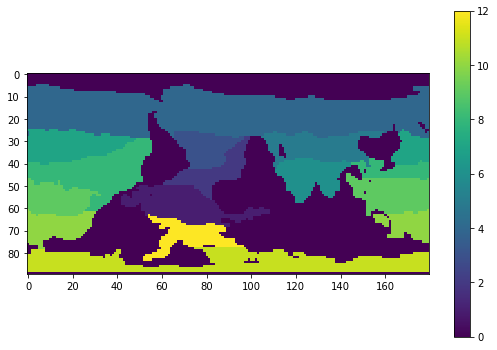

In [9]:
regions = pd.read_csv(os.path.join(DATA_DIR,'Regions/regions.csv'), header=None).values
reg_lon = np.loadtxt(os.path.join(DATA_DIR,'Regions/lons.csv'), delimiter=',').astype(int)
reg_lat = np.loadtxt(os.path.join(DATA_DIR,'Regions/lats.csv'), delimiter=',').astype(int)

# Show mask 
fig,ax = plt.subplots(figsize=(9,6))
c = ax.imshow(regions, interpolation='none')
cbar = plt.colorbar(c,ax=ax)
plt.show()

### Conversion factors as in Table 1

**nifH to cell counts:**

In [15]:
#tri_l = 6.08e-03
#tri_h = 3.47e-00
#UCYNA_l = 1.83e-05
#UCYNA_h = 1.91e-03
#UCYNB_l = 5.00e-05
#UCYNB_h = 1.16e-03
#Ric_l = 1.52e-03
#Ric_h = 8.16e-01

#conversion_nif_cell_low = [tri_l, UCYNA_l, UCYNB_l, Ric_l]
#conversion_nif_cell_high = [tri_h, UCYNA_h, UCYNB_h, Ric_h]

In [10]:
tri_l = 0.002
tri_h = 0.01
UCYNA_l = 0.036
UCYNA_h = 2.04
UCYNB_l = 0.278
UCYNB_h = 0.278
Ric_l = 0.001
Ric_h = 0.01

conversion_nif_cell_low = [tri_l, UCYNA_l, UCYNB_l, Ric_l]
conversion_nif_cell_high = [tri_h, UCYNA_h, UCYNB_h, Ric_h]

**nifH to biomass:**

In [11]:
tri_low = 1.22e-05
tri_high = 3.47e-02
UCYNA_low = 6.59e-07
UCYNA_high = 3.89e-03
UCYNB_low = 1.39e-05
UCYNB_high = 3.24e-04
Ric_low = 5.73e-07
Ric_high = 1.09e-05

conversion_low = [tri_low, UCYNA_low, UCYNB_low, Ric_low]
conversion_high = [tri_high, UCYNA_high, UCYNB_high, Ric_high]

### Load data from Tang and Cassar (2019) database

In [3]:
diazotroph_observations = pd.read_csv(os.path.join(DATA_DIR,'nifH_Gene_Integral_mod.csv'))

# Single columns of nifH database in list format
nifH_Tri = diazotroph_observations['Trichodesmium nifH Gene (x106 copies m-2)']
nifH_UCYN_A = diazotroph_observations['UCYN-A nifH Gene (x106 copies m-2)']
nifH_UCYN_B = diazotroph_observations['UCYN-B nifH Gene (x106 copies m-2)']
nifH_UCYN_C = diazotroph_observations['UCYN-C nifH Gene (x106 copies m-2)']
nifH_Richelia = diazotroph_observations['Richelia nifH Gene (x106 copies m-2)']
nifH_Calothrix = diazotroph_observations['Calothrix nifH Gene  (x106 copies m-2)']
nifH_Gamma = diazotroph_observations['Gamma nifH Gene (x106 copies/m3)']
lon_nifH = diazotroph_observations['LONGITUDE']
lat_nifH = diazotroph_observations['LATITUDE']
year = diazotroph_observations['YEAR']
month = diazotroph_observations['MONTH']

mytypes = [
    'Trichodesmium nifH Gene (x106 copies m-2)',
    'UCYN-A nifH Gene (x106 copies m-2)',
    'UCYN-B nifH Gene (x106 copies m-2)',
    'UCYN-C nifH Gene (x106 copies m-2)',
    'Richelia nifH Gene (x106 copies m-2)',
    'Calothrix nifH Gene  (x106 copies m-2)',
    'Gamma nifH Gene (x106 copies/m3)',
    ]

mytypes_short = [
    'Trichodesmium nifH Gene (x106 copies m-2)',
    'UCYN-A nifH Gene (x106 copies m-2)',
    'UCYN-B nifH Gene (x106 copies m-2)',
    'Richelia nifH Gene (x106 copies m-2)',
    ]

#### Data processing

In [5]:
# sum all nifH gene measurements up
nifH = diazotroph_observations[mytypes_short]
nifH_sum = nifH.sum(1)

In [6]:
nifH

,Trichodesmium nifH Gene (x106 copies m-2),UCYN-A nifH Gene (x106 copies m-2),UCYN-B nifH Gene (x106 copies m-2),Richelia nifH Gene (x106 copies m-2)
0,12000.00,6800.00,14000.00,NaN
1,16000.00,2100.00,8500.00,NaN
2,2100.00,1300.00,1500.00,NaN
3,1500.00,1700.00,560.00,NaN
4,12000.00,860.00,590.00,NaN
...,...,...,...,...
258,6122.56,0.00,0.11,0.31
259,38433.49,0.06,101.62,46.68
260,11165.60,0.01,0.56,870.25
261,20877.89,0.02,5.72,226.14


In [14]:
# calculate biomass conversions from nifH abundance using lowest and highest conversions for each group
bm_Tri_range = (nifH[mytypes_short[0]]*conversion_high[0])-(nifH[mytypes_short[0]]*conversion_low[0])
bm_UCYNA_range = (nifH[mytypes_short[1]]*conversion_high[1])-(nifH[mytypes_short[1]]*conversion_low[1])
bm_UCYNB_range = (nifH[mytypes_short[2]]*conversion_high[2])-(nifH[mytypes_short[2]]*conversion_low[2])
bm_Ric_range = (nifH[mytypes_short[3]]*conversion_high[3])-(nifH[mytypes_short[3]]*conversion_low[3])

# calculate mean biomass from nifH abundance for each group
bm_Tri_mean = ((conversion_high[0]+conversion_low[0])/2)*nifH[mytypes_short[0]]
bm_UCYNA_mean = ((conversion_high[1]+conversion_low[1])/2)*nifH[mytypes_short[1]]
bm_UCYNB_mean = ((conversion_high[2]+conversion_low[2])/2)*nifH[mytypes_short[2]]
bm_Ric_mean = ((conversion_high[3]+conversion_low[3])/2)*nifH[mytypes_short[3]]

### Interpolator

In [15]:
# Prepare interpolator - Regions from Darwin mask

darwin_lon = np.mod(lon, 360.)
darwin_lat = lat
#regions = np.fromfile('mask_darwin.int64_360x160.bin', 'int64').reshape(160, 360)

j, i = np.mgrid[:160, :360]

# create interpolator
I = si.RegularGridInterpolator((reg_lat, reg_lon), regions, 'nearest',
                               bounds_error=False, fill_value=None)

Ii = si.RegularGridInterpolator((darwin_lat, darwin_lon), i, 'nearest',
                                bounds_error=False, fill_value=None)
Ij = si.RegularGridInterpolator((darwin_lat, darwin_lon), j, 'nearest',
                                bounds_error=False, fill_value=None)

# assign each observation with corresponding region (Teng et al., 2014)
n_d = len(lon_nifH)
latlon = np.zeros((n_d, 2))
latlon[:,0] = lat_nifH
latlon[:,1] = np.mod(lon_nifH+180.5, 360) - 180.5

# indices of darwin grid cells containing nifH observations
i_nifH = Ii(latlon).astype(int)
j_nifH = Ij(latlon).astype(int)

# interpolate
nifH_reg = I(latlon).astype(int)

nifH_reg_Tri = nifH_reg[nifH_Tri>0]
nifH_reg_UCYN_A = nifH_reg[nifH_UCYN_A>0]
nifH_reg_UCYN_B = nifH_reg[nifH_UCYN_B>0]
nifH_reg_Richelia = nifH_reg[nifH_Richelia>0]

In [16]:
# interpolate Darwin diazotroph simulations
lm = grid.HFacC[0].values == 0

reg_lat_d = np.arange(-89., 90., 2.)
reg_lon_d = np.arange(-181., 178., 2.)

# extend for periodicity in lon
reg_lon_extended = np.r_[reg_lon_d-360, reg_lon_d, reg_lon_d+360]
regions_extended = np.c_[regions, regions, regions]

# make 2d
yr, xr = np.meshgrid(reg_lat_d, reg_lon_extended, indexing='ij')

# do not use land values
w = regions_extended != 0

# make target coordinates 2d
xo, yo = np.meshgrid(lat, (lon+182)%360-182, indexing='ij')

# map
reg_darwin = si.griddata((yr[w],xr[w]), regions_extended[w], (xo.ravel(), yo.ravel()), 'nearest')
reg_darwin = reg_darwin.reshape(160, 360)
reg_darwin[lm] = 0

## Analyses of nifH data

### Depth integrated nifH gene abundance observations from Tang and Cassar (2019) evaluated for 12 oceanic region boundaries (Teng et al., 2014) used in the analyse

**Plot mean nifH abundance per group and total for each ocean basin:**

<ipython-input-17-cab3b9e258fe>:68: RuntimeWarning: Mean of empty slice
  nif_tot = np.nanmean(nifH[mytypes_short[:]][nifH_reg==i], axis=(0))
<ipython-input-17-cab3b9e258fe>:68: RuntimeWarning: Mean of empty slice
  nif_tot = np.nanmean(nifH[mytypes_short[:]][nifH_reg==i], axis=(0))
<ipython-input-17-cab3b9e258fe>:68: RuntimeWarning: Mean of empty slice
  nif_tot = np.nanmean(nifH[mytypes_short[:]][nifH_reg==i], axis=(0))
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does n

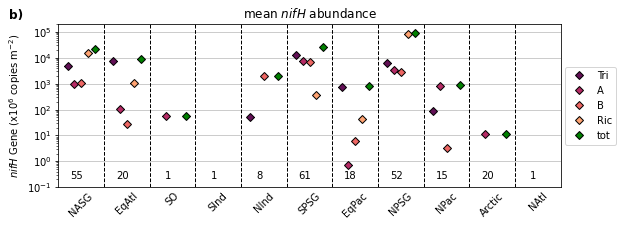

In [17]:
def statsfun(x, label):
    stats = {
        'med': x.sum(),
        'q1': x.sum(),
        'q3': x.sum(),
        'whislo': x.sum(),
        'whishi': x.sum(),
        'mean': np.nansum(x),
        'label': label,
        }
    return stats

# Make boxplots for the regions
regs = np.arange(1,13,1)

def statsfun2(x, label):
    stats = {
        'med': x.mean(),
        'q1': x.mean(),
        'q3': x.mean(),
        'whislo': x.mean(),
        'whishi': x.mean(),
        'mean': x.mean(),
        'label': label,
        }
    return stats

# chose species (0=Trichodesmium, 1=UCYN_A, 2=UCYN_B, 3=Richlia)
species = 0
species_labels = ['Trichodesmium', 'UCYN_A', 'UCYN_B', 'Richelia']
specs_labels = ['Tri.', 'UCYN_A', 'UCYN_B', 'Richelia']
#region_labels = np.arange(0,13,1)
region_labels = ['','NASG', 'EqAtl', 'SASG', 'SO', 'SInd', 'NInd', 'SPSG', 'EqPac', 'NPSG', 'NPac', 'Arctic','NAtl']
#set axes limits
ymin = 1e-01
ymax = 2e05

medianprops = dict(linestyle='-.', linewidth=0, color='k')
meanprops_Tri = dict(marker='D', markeredgecolor='black', markerfacecolor='#621055')
meanprops_A = dict(marker='D', markeredgecolor='black', markerfacecolor='#b52b65')
meanprops_B = dict(marker='D', markeredgecolor='black', markerfacecolor='#ed6663')
meanprops_Ric = dict(marker='D', markeredgecolor='black', markerfacecolor='#ffa372')
meanprops_tot = dict(marker='D', markeredgecolor='black', markerfacecolor='green')


fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
bxpstats = []
ax.set_ylabel('$\it{nifH}$ Gene (x10$^{6}$ copies m$^{-2}$)')
ax.set_title('mean $\it{nifH}$ abundance')
ax.set_yscale('log')
#ax.set_xlim(right=0) 
ax.set_ylim([ymin,ymax])
ax.tick_params(axis='x', bottom=False, pad=0, labelrotation=45)
#ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',
#               alpha=0.5)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey',
               alpha=0.5)

pos = 0
for i in regs:
    if np.sum(nifH_reg==i) > 0:
        nif_Tri = nifH[mytypes_short[0]][nifH_reg==i]
        nif_A = nifH[mytypes_short[1]][nifH_reg==i]
        nif_B = nifH[mytypes_short[2]][nifH_reg==i]
        nif_Ric = nifH[mytypes_short[3]][nifH_reg==i]
        nif_tot = nifH_sum[nifH_reg==i]
        #nif_tot = np.nansum(nifH[mytypes_short[:]][nifH_reg==i], axis=(0,1))
        nif_tot = np.nanmean(nifH[mytypes_short[:]][nifH_reg==i], axis=(0))
        nif_Tri_stats = statsfun2(nif_Tri,'')
        nif_A_stats = statsfun2(nif_A,'')
        nif_B_stats = statsfun2(nif_B,str(region_labels[i]))
        nif_Ric_stats = statsfun2(nif_Ric,'')
        nif_tot_stats = statsfun(nif_tot,'')

        c0 = ax.bxp([nif_Tri_stats], positions=[pos-0.6], showmeans=True, meanprops=meanprops_Tri, medianprops=medianprops, showfliers=False, meanline=False)
        c1 = ax.bxp([nif_A_stats], positions=[pos-0.45], showmeans=True, meanprops=meanprops_A, medianprops=medianprops, showfliers=False, meanline=False)
        c2 = ax.bxp([nif_B_stats], positions=[pos-0.3], showmeans=True, meanprops=meanprops_B, medianprops=medianprops, showfliers=False, meanline=False)
        c3 = ax.bxp([nif_Ric_stats], positions=[pos-0.15], showmeans=True, meanprops=meanprops_Ric, medianprops=medianprops, showfliers=False, meanline=False)
        c4 = ax.bxp([nif_tot_stats], positions=[pos], showmeans=True, meanprops=meanprops_tot, medianprops=medianprops, showfliers=False, meanline=False)
        if pos < 10:
            ax.axvline(pos+0.2, color='k', ls='dashed',linewidth=1)
        ax.annotate(str(np.sum(nifH_reg==i)), (pos-.4,2*ymin), va='baseline', ha='center', xycoords='data')
        pos += 1

ax.set_xlim(-1+.2, pos-1+.2) 

plt.suptitle('b)',x=0.06,y=0.95,fontsize=12,weight='bold')
    
means = [c['means'][0] for c in [c0,c1,c2,c3,c4]]
ax.legend(means, 'Tri A B Ric tot'.split(),loc='center right', bbox_to_anchor=(1.12, 0.5))
fig.savefig(os.path.join(PLOT_DIR,'mean_nifH_abundance_species-specific.eps'), bbox_inches='tight', dpi=300)
plt.show()

**Plot range of deducted cell counts from mean nifH abundance per group for each ocean basin:**

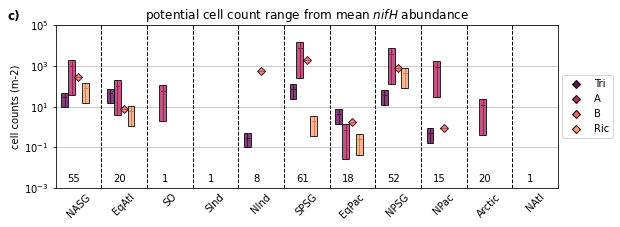

In [19]:
def statsfun3(x, label):
    stats = {
        'med': x.mean(),
        'q1': x.max(),
        'q3': x.min(),
        'whislo': x.mean(),
        'whishi': x.mean(),
        'mean': x.mean(),
        'label': label,
        }
    return stats

# chose species (0=Trichodesmium, 1=UCYN_A, 2=UCYN_B, 3=Richlia)
species = 0
species_labels = ['Trichodesmium', 'UCYN_A', 'UCYN_B', 'Richelia']
specs_labels = ['Tri.', 'UCYN_A', 'UCYN_B', 'Richelia']
#set axes limits
ymin = 1e-03
ymax = 1e05

medianprops = dict(linestyle='-.', linewidth=0, color='k')

meanprops_B_cell = dict(marker='D', markeredgecolor='black', markerfacecolor='#ed6663', alpha=0.8)
boxprops_Tri = dict(edgecolor='black', facecolor='#621055', alpha=0.8)
boxprops_A   = dict(edgecolor='black', facecolor='#b52b65', alpha=0.8)
boxprops_B   = dict(edgecolor='black', facecolor='#ed6663', alpha=0.8)
boxprops_Ric = dict(edgecolor='black', facecolor='#ffa372', alpha=0.8)
boxprops_tot = dict(edgecolor='black', facecolor='lightgreen')

bxpkw = dict(showfliers=False, showmeans=False, medianprops=medianprops, patch_artist=True)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
bxpstats = []
ax.set_ylabel('cell counts (m-2)')
ax.set_title('potential cell count range from mean $\it{nifH}$ abundance')
ax.set_yscale('log')
ax.set_ylim([ymin,ymax])
ax.tick_params(axis='x', bottom=False, pad=0, labelrotation=45)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey',alpha=0.5)

pos = 0
for i in regs:
    if np.sum(nifH_reg==i) > 0:
        cell_Tri = np.append(np.mean(nifH[mytypes_short[0]][nifH_reg==i])*conversion_nif_cell_low[0],np.mean(nifH[mytypes_short[0]][nifH_reg==i])*conversion_nif_cell_high[0])
        cell_A = np.append(np.mean(nifH[mytypes_short[1]][nifH_reg==i])*conversion_nif_cell_low[1],np.mean(nifH[mytypes_short[1]][nifH_reg==i])*conversion_nif_cell_high[1])
        cell_B = np.append(np.mean(nifH[mytypes_short[2]][nifH_reg==i])*conversion_nif_cell_low[2],np.mean(nifH[mytypes_short[2]][nifH_reg==i])*conversion_nif_cell_high[2])
        cell_Ric = np.append(np.mean(nifH[mytypes_short[3]][nifH_reg==i])*conversion_nif_cell_low[3],np.mean(nifH[mytypes_short[3]][nifH_reg==i])*conversion_nif_cell_high[3])
        cell_Tri_stats = statsfun3(cell_Tri,'')
        cell_A_stats = statsfun3(cell_A,'')
        cell_B_stats = statsfun2(cell_B,str(region_labels[i]))
        cell_Ric_stats = statsfun3(cell_Ric,'')
        ax.bxp([cell_Tri_stats], positions=[pos-0.6], boxprops=boxprops_Tri, **bxpkw)
        ax.bxp([cell_A_stats], positions=[pos-0.45], boxprops=boxprops_A, **bxpkw)
        #ax.bxp([cell_B_stats], positions=[pos-0.3],  boxprops=boxprops_B, **bxpkw)
        ax.bxp([cell_B_stats], positions=[pos-0.3], showmeans=True, meanprops=meanprops_B_cell, medianprops=medianprops, showfliers=False, meanline=False)
        ax.bxp([cell_Ric_stats], positions=[pos-0.15], boxprops=boxprops_Ric, **bxpkw)
        if pos < 10:
            ax.axvline(pos+0.2, color='k', ls='dashed',linewidth=1)
        ax.annotate(str(np.sum(nifH_reg==i)), (pos-.4,2*ymin), va='baseline', ha='center', xycoords='data')
        pos += 1

ax.set_xlim(-1+.2, pos-1+.2) 
means = [c['means'][0] for c in [c0,c1,c2,c3]]
ax.legend(means, 'Tri A B Ric'.split(),loc='center right', bbox_to_anchor=(1.12, 0.5))      
fig.suptitle('c)',x=0.06,y=0.95,fontsize=12,weight='bold')
#fig.savefig(os.path.join(PLOT_DIR, 'mean_cell-from-nifH_species-specific.pdf'), bbox_inches='tight', dpi=300)
plt.show()

**Plot range of deducted biomass from mean nifH abundance per group for each ocean basin:**

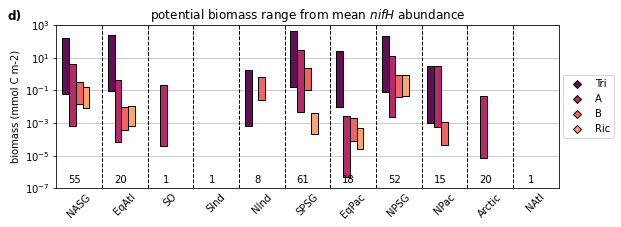

In [55]:
# chose species (0=Trichodesmium, 1=UCYN_A, 2=UCYN_B, 3=Richlia)
species = 0
species_labels = ['Trichodesmium', 'UCYN_A', 'UCYN_B', 'Richelia']
specs_labels = ['Tri.', 'UCYN_A', 'UCYN_B', 'Richelia']
#set axes limits
ymin = 1e-07
ymax = 1e03

medianprops = dict(linestyle='-.', linewidth=0, color='k')

boxprops_Tri = dict(edgecolor='black', facecolor='#621055')
boxprops_A   = dict(edgecolor='black', facecolor='#b52b65')
boxprops_B   = dict(edgecolor='black', facecolor='#ed6663')
boxprops_Ric = dict(edgecolor='black', facecolor='#ffa372')
boxprops_tot = dict(edgecolor='black', facecolor='lightgreen')

bxpkw = dict(showfliers=False, showmeans=False, medianprops=medianprops, patch_artist=True)

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
bxpstats = []
ax.set_ylabel('biomass (mmol C m-2)')
ax.set_title('potential biomass range from mean $\it{nifH}$ abundance')
ax.set_yscale('log')
ax.set_ylim([ymin,ymax])
ax.tick_params(axis='x', bottom=False, pad=0, labelrotation=45)
ax.yaxis.grid(True, linestyle='-', which='major', color='grey',alpha=0.5)
pos = 0
for i in regs:
    if np.sum(nifH_reg==i) > 0:
        bm_Tri = np.append(np.mean(nifH[mytypes_short[0]][nifH_reg==i])*conversion_low[0],np.mean(nifH[mytypes_short[0]][nifH_reg==i])*conversion_high[0])
        bm_A = np.append(np.mean(nifH[mytypes_short[1]][nifH_reg==i])*conversion_low[1],np.mean(nifH[mytypes_short[1]][nifH_reg==i])*conversion_high[1])
        bm_B = np.append(np.mean(nifH[mytypes_short[2]][nifH_reg==i])*conversion_low[2],np.mean(nifH[mytypes_short[2]][nifH_reg==i])*conversion_high[2])
        bm_Ric = np.append(np.mean(nifH[mytypes_short[3]][nifH_reg==i])*conversion_low[3],np.mean(nifH[mytypes_short[3]][nifH_reg==i])*conversion_high[3])
        bm_Tri_stats = statsfun3(bm_Tri,'')
        bm_A_stats = statsfun3(bm_A,'')
        bm_B_stats = statsfun3(bm_B,str(region_labels[i]))
        bm_Ric_stats = statsfun3(bm_Ric,'')
        ax.bxp([bm_Tri_stats], positions=[pos-0.6], boxprops=boxprops_Tri, **bxpkw)
        ax.bxp([bm_A_stats], positions=[pos-0.45], boxprops=boxprops_A, **bxpkw)
        ax.bxp([bm_B_stats], positions=[pos-0.3],  boxprops=boxprops_B, **bxpkw)
        ax.bxp([bm_Ric_stats], positions=[pos-0.15], boxprops=boxprops_Ric, **bxpkw)
        if pos < 10:
            ax.axvline(pos+0.2, color='k', ls='dashed',linewidth=1)
        ax.annotate(str(np.sum(nifH_reg==i)), (pos-.4,2*ymin), va='baseline', ha='center', xycoords='data')
        pos += 1

ax.set_xlim(-1+.2, pos-1+.2) 
means = [c['means'][0] for c in [c0,c1,c2,c3]]
ax.legend(means, 'Tri A B Ric'.split(),loc='center right', bbox_to_anchor=(1.12, 0.5))      
fig.suptitle('d)',x=0.06,y=0.95,fontsize=12,weight='bold')
#fig.savefig(os.path.join(PLOT_DIR,'mean_bm-from-nifH_species-specific.pdf'), bbox_inches='tight', dpi=300)
plt.show()

### Predicted biomass from nifH abundance evalutated at sample location

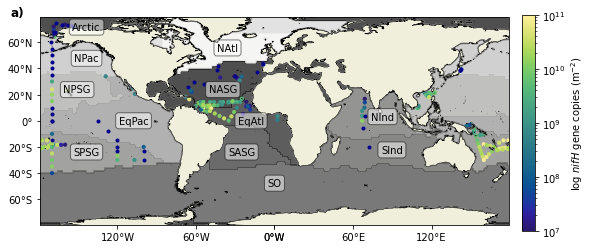

In [57]:
col = cm.cm.haline
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

reg_darwin180 = np.roll(reg_darwin, 180, 1)
lon180 = np.mod(np.roll(lon,180)+180, 360) - 180

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(9,4))
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.coastlines(color='#888888',linewidth=1.5)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', linewidth=0.5, facecolor=cfeature.COLORS['land']))
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
c0 = ax.contourf(lon180,lat,reg_darwin180,levels=np.linspace(0,12,13),cmap=cm.cm.gray,extend='max',alpha=0.7)
#c1 = ax.scatter(lon_nifH,lat_nifH,s=10,c=nifH_sum,norm=plt.Normalize(0,10000),cmap=col)
c1 = ax.scatter(lon_nifH,lat_nifH,s=10,c=nifH_sum,norm=colors.LogNorm(10e0,10e4),cmap=col)
c2 = ax.plot(lon_nifH[np.where(nifH_sum == 0.0)[0]],lat_nifH[np.where(nifH_sum == 0.0)[0]],'.',color='darkblue',markersize=6)
c3 = ax.scatter(lon_nifH,lat_nifH,s=0,c=nifH_sum,norm=colors.LogNorm(10e6,10e10),cmap=col) #just for the colorbarlabels
ax.text(0.39,0.65,'NASG',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.45,0.5,'EqAtl',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.43,0.35,'SASG',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.5,0.2,'SO',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.75,0.36,'SInd',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.1,0.35,'SPSG',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.2,0.5,'EqPac',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.08,0.65,'NPSG',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.1,0.8,'NPac',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.1,0.95,'Arctic',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.4,0.85,'NAtl',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
ax.text(0.73,0.52,'NInd',transform=ax.transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w',alpha=0.5))
['','NASG', 'EqAtl', 'SASG', 'SO', 'SInd', 'NInd', 'SPSG', 'EqPac', 'NPSG', 'NPac', 'Arctic','NAtl']
fig.subplots_adjust(wspace=0.07,hspace=0.07,right=0.85)
cbar_ax = fig.add_axes([0.87, 0.12, 0.02, 0.75])
cbar = fig.colorbar(c3, cax=cbar_ax)
cbar.set_label('log $\it{nifH}$ gene copies (m$^{-2}$)',rotation=90, position=(0.5,0.5))
fig.suptitle('a)',x=0.09,y=0.9,fontsize=12,weight='bold')
#fig.savefig(os.path.join(PLOT_DIR,'diaz_Darwin_overview_nifH_regions.png'), bbox_inches='tight', dpi=300)
plt.show()

**Predicted mean biomass from $\it{nifH}$ abundance for each diazotrophic group:**

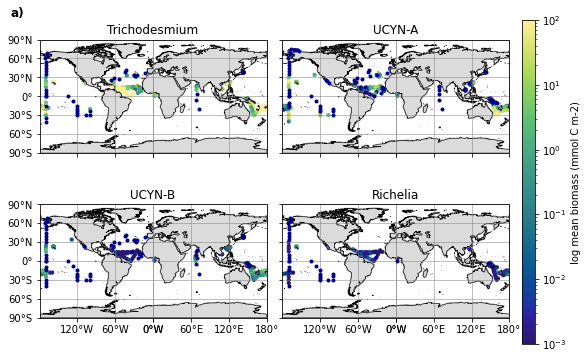

In [27]:
col = cm.cm.haline
from matplotlib.colors import LogNorm

reg_darwin180 = np.roll(reg_darwin, 180, 1)
lon180 = np.mod(np.roll(lon,180)+180, 360) - 180
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

bm_mean = [bm_Tri_mean, bm_UCYNA_mean, bm_UCYNB_mean, bm_Ric_mean]
title = ['Trichodesmium','UCYN-A','UCYN-B','Richelia']
fig,ax = plt.subplots(2,2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},sharex=True, sharey=True, figsize=(9,6))

m = 0
for i in range(2):
    for j in range(2):
        ax[i,j].coastlines(color='#888888',linewidth=1.5)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', linewidth=0.5, facecolor=cfeature.COLORS['land_alt1']))
        ax[i,j].xaxis.set_major_formatter(lon_formatter)
        ax[i,j].yaxis.set_major_formatter(lat_formatter)
        ax[i,j].set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
        ax[i,j].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        ax[i,j].set_ylim([-90, 90])
        ax[1,j].xaxis.set_major_formatter(lon_formatter)
        ax[i,0].yaxis.set_major_formatter(lat_formatter)       
        ax[i,j].grid(color='grey', linestyle='-', linewidth=0.5)
        ax[i,j].set_title(title[m])
        c0 = ax[i,j].scatter(lon_nifH,lat_nifH,s=10,c=bm_mean[m],norm=colors.LogNorm(10e-4,100),cmap=col)
        c1 = ax[i,j].plot(lon_nifH[np.where(bm_mean[m] == 0.0)[0]],lat_nifH[np.where(bm_mean[m] == 0.0)[0]],'.',color='darkblue',markersize=6)
        m += 1
fig.subplots_adjust(wspace=0.07,hspace=0.02,right=0.85)
cbar_ax = fig.add_axes([0.87, 0.12, 0.02, 0.75])
cbar = fig.colorbar(c0, cax=cbar_ax)
cbar.set_label('log mean biomass (mmol C m-2)',rotation=90, position=(0.5,0.5))
fig.suptitle('a)',x=0.09,y=0.9,fontsize=12,weight='bold')
#fig.savefig(os.path.join(PLOT_DIR,'diaz_nifH_map_bm_mean.pdf'), bbox_inches='tight', dpi=300)
plt.show()

**Predicted biomass range from $\it{nifH}$ abundance for each diazotrophic group:**

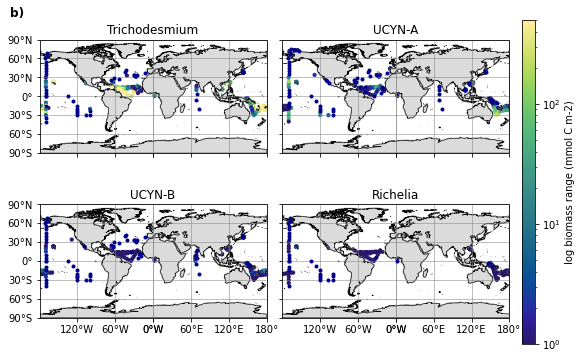

In [28]:
col = cm.cm.haline
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

reg_darwin180 = np.roll(reg_darwin, 180, 1)
lon180 = np.mod(np.roll(lon,180)+180, 360) - 180
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

bm_range = [bm_Tri_range, bm_UCYNA_range, bm_UCYNB_range, bm_Ric_range]
title = ['Trichodesmium','UCYN-A','UCYN-B','Richelia']
fig,ax = plt.subplots(2,2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},sharex=True, sharey=True, figsize=(9,6))
m = 0
for i in range(2):
    for j in range(2):
        ax[i,j].coastlines(color='#888888',linewidth=1.5)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', linewidth=0.5, facecolor=cfeature.COLORS['land_alt1']))
        ax[i,j].xaxis.set_major_formatter(lon_formatter)
        ax[i,j].yaxis.set_major_formatter(lat_formatter)
        ax[i,j].set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
        ax[i,j].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        ax[i,j].set_ylim([-90, 90])
        ax[1,j].xaxis.set_major_formatter(lon_formatter)
        ax[i,0].yaxis.set_major_formatter(lat_formatter)       
        ax[i,j].grid(color='grey', linestyle='-', linewidth=0.5)
        ax[i,j].set_title(title[m])
        c0 = ax[i,j].scatter(lon_nifH,lat_nifH,s=10,c=bm_range[m],norm=colors.LogNorm(1,500),cmap=col)
        c1 = ax[i,j].plot(lon_nifH[np.where(bm_range[m] == 0.0)[0]],lat_nifH[np.where(bm_range[m] == 0.0)[0]],'.',color='darkblue',markersize=6)
        m += 1
fig.subplots_adjust(wspace=0.07,hspace=0.02,right=0.85)
cbar_ax = fig.add_axes([0.87, 0.12, 0.02, 0.75])
cbar = fig.colorbar(c0, cax=cbar_ax)
cbar.set_label('log biomass range (mmol C m-2)',rotation=90, position=(0.5,0.5))
fig.suptitle('b)',x=0.09,y=0.9,fontsize=12,weight='bold')
#fig.savefig(os.path.join(PLOT_DIR,'diaz_nifH_map_bm_range.pdf'), bbox_inches='tight', dpi=300)
plt.show()

## Darwin model analyses

### Maps of depth-integrated mean annual diazotroph biomass 

**Model "RUN19_33_MONTH":**

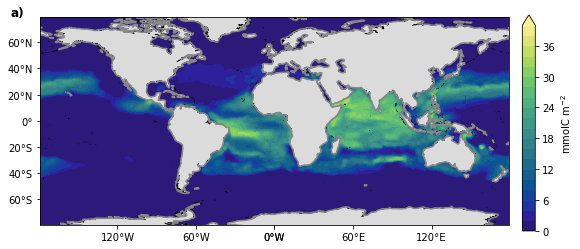

In [29]:
col = cm.cm.haline
lon180 = np.mod(np.roll(lon,180)+180, 360) - 180
diaz_int180 = np.roll(diaz_int, 180, 1)

fig,ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(9,4))
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', linewidth=0.5, facecolor=cfeature.COLORS['land_alt1']))
ax.coastlines(color='#888888',linewidth=1.5)
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
ax.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
c0 = ax.contourf(lon180,lat,diaz_int180,levels=np.linspace(0,40,21),cmap=col,extend='max')
fig.subplots_adjust(wspace=0.07,hspace=0.07,right=0.85)
cbar_ax = fig.add_axes([0.87, 0.12, 0.02, 0.75])
cbar = fig.colorbar(c0, cax=cbar_ax)
cbar.set_label('mmolC m$^{-2}$',rotation=90, position=(0.5,0.5))
plt.suptitle('a)',x=0.09,y=0.9,fontsize=12,weight='bold')
#fig.savefig(os.path.join(PLOT_DIR,'diaz_Darwin_overview_model1.pdf'), bbox_inches='tight', dpi=300)
plt.show()

**Other models:**

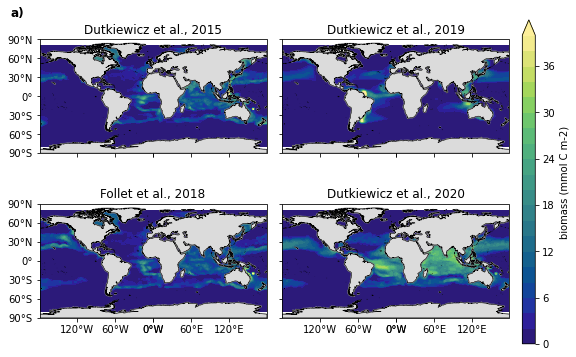

In [58]:
col = cm.cm.haline
from matplotlib.colors import LogNorm
import matplotlib.colors as colors

lon180 = np.mod(np.roll(lon,180)+180, 360) - 180
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()

diaz_sim_tot = [diaz_tot_D15,diaz_tot_D19,diaz_tot_F18,diaz_tot_D20]
title = ['Dutkiewicz et al., 2015','Dutkiewicz et al., 2019','Follet et al., 2018','Dutkiewicz et al., 2020']
fig,ax = plt.subplots(2,2, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},sharex=True, sharey=True, figsize=(9,6))

m = 0
for i in range(2):
    for j in range(2):
        ax[i,j].coastlines(color='#888888',linewidth=1.5)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', linewidth=0.5, facecolor=cfeature.COLORS['land_alt1']))
        ax[i,j].xaxis.set_major_formatter(lon_formatter)
        ax[i,j].yaxis.set_major_formatter(lat_formatter)
        ax[i,j].set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
        ax[i,j].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
        ax[i,j].set_ylim([-90, 90])
        ax[1,j].xaxis.set_major_formatter(lon_formatter)
        ax[i,0].yaxis.set_major_formatter(lat_formatter)       
        ax[i,j].set_title(title[m])
        c0 = ax[i,j].contourf(lon180,lat,np.roll(diaz_sim_tot[m], 180, 1),levels=np.linspace(0,40,21),cmap=col,extend='max')
        m += 1
fig.subplots_adjust(wspace=0.07,hspace=0.02,right=0.85)
cbar_ax = fig.add_axes([0.87, 0.12, 0.02, 0.75])
cbar = fig.colorbar(c0, cax=cbar_ax)
cbar.set_label('biomass (mmol C m-2)',rotation=90, position=(0.5,0.5))
#fig.suptitle('a)',x=0.09,y=0.9,fontsize=12,weight='bold')
fig.savefig(os.path.join(PLOT_DIR,'diaz_Darwin_overview_models.pdf'), bbox_inches='tight', dpi=300)
plt.show()

### Comparison model simulations vs. biomass from nifH abundance

In [59]:
# calculate mean biomass
# Create empty array and fill with values of converted biomass for each species from nifH abundance
shape = len(nifH),len(mytypes_short)
bm_nifH = np.zeros(shape) 
bm_low = np.zeros(shape) 
bm_high = np.zeros(shape)        

for i in range(0,len(mytypes_short)):
    bm_nifH[:,i] = nifH[mytypes_short[i]]
    bm_low[:,i] = bm_nifH[:,i]*conversion_low[i]
bm_low_tot = np.nansum(bm_low,axis=1)

for i in range(0,len(mytypes_short)):
    bm_nifH[:,i] = nifH[mytypes_short[i]]
    bm_high[:,i] = bm_nifH[:,i]*conversion_high[i]
bm_high_tot = np.nansum(bm_high,axis=1)

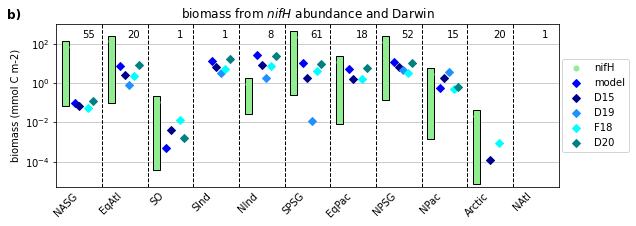

In [60]:
def statsfun4(x, label):
    stats = {
        'med': np.median(x),
        'q1': x.mean(),
        'q3': x.mean(),
        #'whislo': -x.std(),
        #'whishi': x.std(),
        'whislo': x.mean(),
        'whishi': x.mean(),
        'mean': x.mean(),
        'label': label,
        }
    return stats

bm_darwin = diaz_int[j_nifH,i_nifH]
bm_D15 = diaz_tot_D15[j_nifH,i_nifH]
bm_D19 = diaz_tot_D19[j_nifH,i_nifH]
bm_F18 = diaz_tot_F18[j_nifH,i_nifH]
bm_D20 = diaz_tot_D20[j_nifH,i_nifH]

boxprops_bm = dict(edgecolor='w', facecolor='w')
boxprops_darwin = dict(edgecolor='black', facecolor='lightblue')
meanprops_m = dict(marker='o', markersize=5,markeredgecolor='lightgreen', markerfacecolor='lightgreen')
meanprops_dar = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='blue', markerfacecolor='blue')
meanprops_D15 = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='darkblue', markerfacecolor='darkblue')
meanprops_D19 = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='dodgerblue', markerfacecolor='dodgerblue')
meanprops_F18 = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='cyan', markerfacecolor='cyan')
meanprops_D20 = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='teal', markerfacecolor='teal')
bxpkw3 = dict(showfliers=False, showmeans=True, meanprops=meanprops_m, medianprops=medianprops, patch_artist=True)
bxpkwDar = dict(showfliers=False, showmeans=True, meanprops=meanprops_dar, medianprops=medianprops, patch_artist=True)
bxpkwD15 = dict(showfliers=False, showmeans=True, meanprops=meanprops_D15, medianprops=medianprops, patch_artist=True)
bxpkwD19 = dict(showfliers=False, showmeans=True, meanprops=meanprops_D19, medianprops=medianprops, patch_artist=True)
bxpkwF18 = dict(showfliers=False, showmeans=True, meanprops=meanprops_F18, medianprops=medianprops, patch_artist=True)
bxpkwD20 = dict(showfliers=False, showmeans=True, meanprops=meanprops_D20, medianprops=medianprops, patch_artist=True)

ymin = 5e-06
ymax = 1e03

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
bxpstats = []
ax.set_ylabel('biomass (mmol C m-2)')
ax.set_title('biomass from $\it{nifH}$ abundance and Darwin')
ax.set_yscale('log')
ax.set_ylim([ymin,ymax])
ax.yaxis.grid(True, linestyle='-', which='major', color='grey',
               alpha=0.5)
ax.tick_params(axis='x', bottom=False, pad=0, labelrotation=45)

pos = 0
for i in regs:
    if np.sum(nifH_reg==i) > 0:
        mean_bm_low = np.mean(bm_low_tot[nifH_reg==i])
        mean_bm_high =  np.mean(bm_high_tot[nifH_reg==i])
        mean_bm_mean = np.append(mean_bm_low, mean_bm_high)
        mean_bm_m = statsfun3(mean_bm_mean,str(region_labels[i]))
        bm_darwin_stats = statsfun4(bm_darwin[nifH_reg==i],'')
        bm_D15_stats = statsfun4(bm_D15[nifH_reg==i],'')
        bm_D19_stats = statsfun4(bm_D19[nifH_reg==i],'')
        bm_F18_stats = statsfun4(bm_F18[nifH_reg==i],'')
        bm_D20_stats = statsfun4(bm_D20[nifH_reg==i],'')
        bm0 = ax.bxp([mean_bm_m], positions=[pos-0.3], boxprops=boxprops_tot, **bxpkw3)
        bm1 = ax.bxp([bm_darwin_stats], positions=[pos-0.1], boxprops=boxprops_darwin, **bxpkwDar)
        bm2 = ax.bxp([bm_D15_stats], positions=[pos-0.0], boxprops=boxprops_darwin, **bxpkwD15)
        bm3 = ax.bxp([bm_D19_stats], positions=[pos+0.1], boxprops=boxprops_darwin, **bxpkwD19)
        bm4 = ax.bxp([bm_F18_stats], positions=[pos+0.2], boxprops=boxprops_darwin, **bxpkwF18)
        bm5 = ax.bxp([bm_D20_stats], positions=[pos+0.3], boxprops=boxprops_darwin, **bxpkwD20)
        if pos < 10:
            ax.axvline(pos+0.5, color='k', ls='dashed',linewidth=1)
        ax.annotate(str(np.sum(nifH_reg==i)), (pos+.2,2*1e02), va='baseline', ha='center', xycoords='data')
        pos += 1

ax.set_xlim(-1+.5, pos-1+.5) 
means = [c['means'][0] for c in [bm0,bm1,bm2,bm3,bm4,bm5]]
ax.legend(means, 'nifH model D15 D19 F18 D20'.split(),loc='center right', bbox_to_anchor=(1.15, 0.5))
fig.suptitle('b)',x=0.06,y=0.95,fontsize=12,weight='bold')
#fig.savefig(os.path.join(PLOT_DIR,'bm_darwin_nifH_5models.pdf'), bbox_inches='tight', dpi=300)
plt.show()

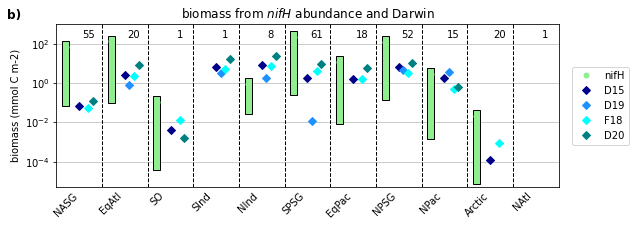

In [61]:
def statsfun4(x, label):
    stats = {
        'med': np.median(x),
        'q1': x.mean(),
        'q3': x.mean(),
        #'whislo': -x.std(),
        #'whishi': x.std(),
        'whislo': x.mean(),
        'whishi': x.mean(),
        'mean': x.mean(),
        'label': label,
        }
    return stats

bm_D15 = diaz_tot_D15[j_nifH,i_nifH]
bm_D19 = diaz_tot_D19[j_nifH,i_nifH]
bm_F18 = diaz_tot_F18[j_nifH,i_nifH]
bm_D20 = diaz_tot_D20[j_nifH,i_nifH]

boxprops_bm = dict(edgecolor='w', facecolor='w')
boxprops_darwin = dict(edgecolor='black', facecolor='lightblue')
meanprops_m = dict(marker='o', markersize=5,markeredgecolor='lightgreen', markerfacecolor='lightgreen')
meanprops_D15 = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='darkblue', markerfacecolor='darkblue')
meanprops_D19 = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='dodgerblue', markerfacecolor='dodgerblue')
meanprops_F18 = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='cyan', markerfacecolor='cyan')
meanprops_D20 = dict(marker='D',markersize=5, alpha=1.0, markeredgecolor='teal', markerfacecolor='teal')
bxpkw3 = dict(showfliers=False, showmeans=True, meanprops=meanprops_m, medianprops=medianprops, patch_artist=True)
bxpkwD15 = dict(showfliers=False, showmeans=True, meanprops=meanprops_D15, medianprops=medianprops, patch_artist=True)
bxpkwD19 = dict(showfliers=False, showmeans=True, meanprops=meanprops_D19, medianprops=medianprops, patch_artist=True)
bxpkwF18 = dict(showfliers=False, showmeans=True, meanprops=meanprops_F18, medianprops=medianprops, patch_artist=True)
bxpkwD20 = dict(showfliers=False, showmeans=True, meanprops=meanprops_D20, medianprops=medianprops, patch_artist=True)

ymin = 5e-06
ymax = 1e03

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
bxpstats = []
ax.set_ylabel('biomass (mmol C m-2)')
ax.set_title('biomass from $\it{nifH}$ abundance and Darwin')
ax.set_yscale('log')
ax.set_ylim([ymin,ymax])
ax.yaxis.grid(True, linestyle='-', which='major', color='grey',
               alpha=0.5)
ax.tick_params(axis='x', bottom=False, pad=0, labelrotation=45)

pos = 0
for i in regs:
    if np.sum(nifH_reg==i) > 0:
        mean_bm_low = np.mean(bm_low_tot[nifH_reg==i])
        mean_bm_high =  np.mean(bm_high_tot[nifH_reg==i])
        mean_bm_mean = np.append(mean_bm_low, mean_bm_high)
        mean_bm_m = statsfun3(mean_bm_mean,str(region_labels[i]))
        bm_D15_stats = statsfun4(bm_D15[nifH_reg==i],'')
        bm_D19_stats = statsfun4(bm_D19[nifH_reg==i],'')
        bm_F18_stats = statsfun4(bm_F18[nifH_reg==i],'')
        bm_D20_stats = statsfun4(bm_D20[nifH_reg==i],'')
        bm0 = ax.bxp([mean_bm_m], positions=[pos-0.3], boxprops=boxprops_tot, **bxpkw3)
        bm2 = ax.bxp([bm_D15_stats], positions=[pos-0.0], boxprops=boxprops_darwin, **bxpkwD15)
        bm3 = ax.bxp([bm_D19_stats], positions=[pos+0.1], boxprops=boxprops_darwin, **bxpkwD19)
        bm4 = ax.bxp([bm_F18_stats], positions=[pos+0.2], boxprops=boxprops_darwin, **bxpkwF18)
        bm5 = ax.bxp([bm_D20_stats], positions=[pos+0.3], boxprops=boxprops_darwin, **bxpkwD20)
        if pos < 10:
            ax.axvline(pos+0.5, color='k', ls='dashed',linewidth=1)
        ax.annotate(str(np.sum(nifH_reg==i)), (pos+.2,2*1e02), va='baseline', ha='center', xycoords='data')
        pos += 1

ax.set_xlim(-1+.5, pos-1+.5) 
means = [c['means'][0] for c in [bm0,bm2,bm3,bm4,bm5]]
ax.legend(means, 'nifH D15 D19 F18 D20'.split(),loc='center right', bbox_to_anchor=(1.15, 0.5))
fig.suptitle('b)',x=0.06,y=0.95,fontsize=12,weight='bold')
#fig.savefig(os.path.join(PLOT_DIR, 'bm_darwin_nifH_4models.pdf'), bbox_inches='tight', dpi=300)
plt.show()

### Presence - non-detect

In [62]:
presence = np.where(nifH_sum[:] > 0)[0]
absence = np.where(nifH_sum[:] == 0)[0]

No handles with labels found to put in legend.


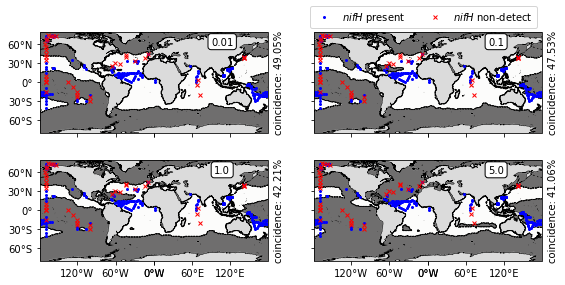

In [63]:
# Presence/non-detect comparison for varying thresholds in Darwin
plt.rcParams.update({'font.size': 10})

new_thresh = [0.01,0.1,1.0,5.0]

lon180 = np.mod(np.roll(lon,180)+180, 360) - 180

#col = plt.get_cmap('RdBu_r')
#col = plt.get_cmap('viridis')
col = cm.cm.gray

fig,ax = plt.subplots(2,2,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(9,4.5),sharex=True,sharey=True)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
fig.subplots_adjust(hspace = 0.1, wspace=0.2)
ax = ax.ravel()

for i in range(0,4):
    mask = np.where((diaz_int > new_thresh[i]), 1, 0)
    I_in = si.RegularGridInterpolator((lat, lon), mask, 'nearest', bounds_error=False, fill_value=None)
    mask_darwin_nifH = I_in(latlon).astype(int)
    mask_nifH = np.where(nifH_sum > 0, 1, 0)

    mask_darwin_nifH = I_in(latlon).astype(int)
    mask_nifH = np.where(nifH_sum > 0, 1, 0)
    mask180 = np.roll(mask, 180, 1)
    ncoincide = np.sum(mask_nifH == mask_darwin_nifH)
    COR = ncoincide/len(nifH)


    ax[i].coastlines(color='#888888',linewidth=1.5)
    ax[i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', linewidth=0.5, facecolor=cfeature.COLORS['land_alt1']))
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    ax[i].set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
    ax[i].set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
    ax[i].text(0.8,0.9,''+(str(new_thresh[i])+''),transform=ax[i].transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w'))
    ax[i].text(1.05,0.5,'coincidence: '+(str("{:.2%}".format(COR)+'')),transform=ax[i].transAxes, size=10, rotation=90.,ha="center", va="center")#,bbox=dict(boxstyle="square",facecolor='w'))
    ax[i].contourf(lon180,lat,mask180,cmap=col,extend='max',levels=np.linspace(-1,1,51))
    ax[i].contour(lon180,lat,mask180, colors='k', linestyles='--', linewidths=0.5)
    ax[i].plot(lon_nifH[presence],lat_nifH[presence],'.',color='b',markersize=4,label='$\it{nifH}$ present')
    ax[i].plot(lon_nifH[absence],lat_nifH[absence],'x',color='r',markersize=4,label='$\it{nifH}$ non-detect')
    ax[1].legend(loc='upper right',ncol=2,bbox_to_anchor=(1, 1.3))

#ax[0].set_title('Seasonal nutrient ratio P:N')
#cbar.set_label(''+str(name_nut[nu])+'',rotation=90, position=(0.5,0.5))
fig.savefig(os.path.join(PLOT_DIR,'diaz_Darwin_overview_mask-in-out_var-thresh_newcolor.jpg'), bbox_inches='tight', dpi=300)
plt.show()

No handles with labels found to put in legend.


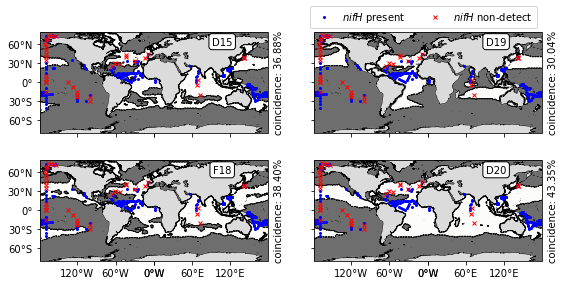

In [64]:
# Repeat the presence/absence comparison on seasonal timescales
thresh = 1

model_list = [diaz_tot_D15, diaz_tot_D19, diaz_tot_F18, diaz_tot_D20]
model_names = ['D15', 'D19', 'F18', 'D20']

plt.rcParams.update({'font.size': 10})
col = cmap=cm.cm.gray
pres_cols = ['red','orange','purple','magenta']
abs_cols = ['lightgreen','green','lime','w']

fig,ax = plt.subplots(2,2,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(9,4.5),sharex=True,sharey=True)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
fig.subplots_adjust(hspace = 0.1, wspace=0.2)
ax = ax.ravel()

for i in range(0,4):
    
    mask = np.where((model_list[i] > thresh), 1, 0)
    I_in = si.RegularGridInterpolator((lat, lon), mask, 'nearest', bounds_error=False, fill_value=None)
    mask_darwin_nifH = I_in(latlon).astype(int)
    mask_nifH = np.where(nifH_sum > 0, 1, 0)

    mask_darwin_nifH = I_in(latlon).astype(int)
    mask_nifH = np.where(nifH_sum > 0, 1, 0)
    mask180 = np.roll(mask, 180, 1)
    ncoincide = np.sum(mask_nifH == mask_darwin_nifH)
    COR = ncoincide/len(nifH)

    ax[i].coastlines(color='#888888',linewidth=1.5)
    ax[i].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', linewidth=0.5, facecolor=cfeature.COLORS['land_alt1']))
    ax[i].xaxis.set_major_formatter(lon_formatter)
    ax[i].yaxis.set_major_formatter(lat_formatter)
    ax[i].set_xticks([0,60,120,180,240,300,360], crs=ccrs.PlateCarree())
    ax[i].set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
    ax[i].text(0.8,0.9, str(model_names[i]),transform=ax[i].transAxes, size=10, rotation=0.,ha="center", va="center",bbox=dict(boxstyle="round",facecolor='w'))
    ax[i].text(1.05,0.5,'coincidence: '+(str("{:.2%}".format(COR)+'')),transform=ax[i].transAxes, size=10, rotation=90.,ha="center", va="center")#,bbox=dict(boxstyle="square",facecolor='w'))
    ax[i].contourf(lon180,lat,mask180,cmap=col,extend='max',levels=np.linspace(-1,1,51))
    ax[i].contour(lon180,lat,mask180, colors='k', linestyles='--', linewidths=0.5)
    ax[i].plot(lon_nifH[presence],lat_nifH[presence],'.',color='b',markersize=4,label='$\it{nifH}$ present')
    ax[i].plot(lon_nifH[absence],lat_nifH[absence],'x',color='r',markersize=4,label='$\it{nifH}$ non-detect')
    ax[1].legend(loc='upper right',ncol=2,bbox_to_anchor=(1, 1.3))
fig.savefig(os.path.join(PLOT_DIR,'diaz_Darwin_overview_mask-in-out_models.pdf'), bbox_inches='tight', dpi=300)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


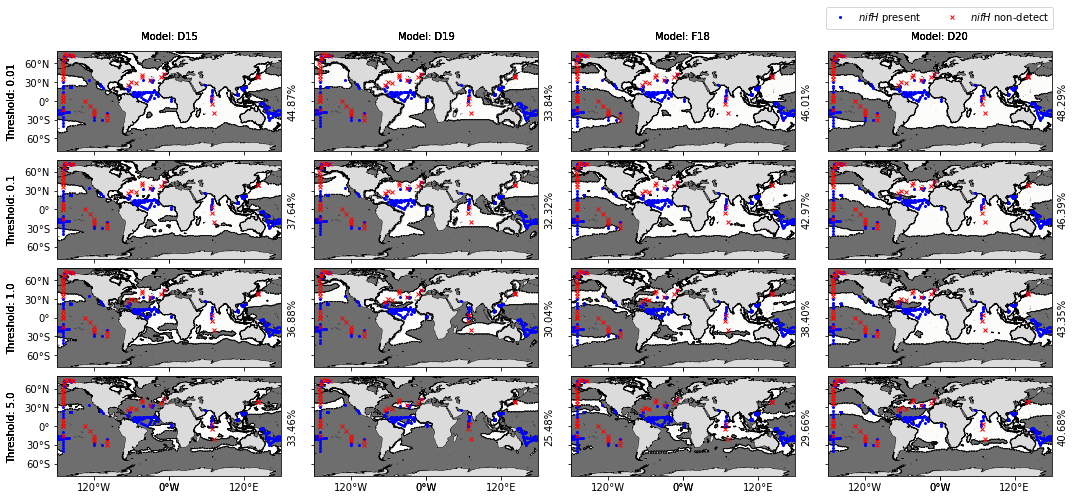

In [65]:
# Repeat the presence/absence comparison on seasonal timescales
thresh = 0.01

model_list = [diaz_tot_D15, diaz_tot_D19, diaz_tot_F18, diaz_tot_D20]
model_names = ['D15', 'D19', 'F18', 'D20']

plt.rcParams.update({'font.size': 10})
col = cm.cm.gray
pres_cols = ['red','orange','purple','magenta']
abs_cols = ['lightgreen','green','lime','w']

fig,ax = plt.subplots(4,4,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)},figsize=(15,7),sharex=True,sharey=True,tight_layout=True)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
#fig.subplots_adjust(hspace = 0.1, wspace=0.2)

for j in range(0,4): #per threshold
    for i in range(0,4): #per model
    
        mask = np.where((model_list[j] > new_thresh[i]), 1, 0)
        I_in = si.RegularGridInterpolator((lat, lon), mask, 'nearest', bounds_error=False, fill_value=None)
        mask_darwin_nifH = I_in(latlon).astype(int)
        mask_nifH = np.where(nifH_sum > 0, 1, 0)

        mask_darwin_nifH = I_in(latlon).astype(int)
        mask_nifH = np.where(nifH_sum > 0, 1, 0)
        mask180 = np.roll(mask, 180, 1)
        ncoincide = np.sum(mask_nifH == mask_darwin_nifH)
        COR = ncoincide/len(nifH)

        ax[i,j].coastlines(color='#888888',linewidth=1.5)
        ax[i,j].add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', linewidth=0.5, facecolor=cfeature.COLORS['land_alt1']))
        ax[i,j].xaxis.set_major_formatter(lon_formatter)
        ax[i,j].yaxis.set_major_formatter(lat_formatter)
        ax[i,j].set_xticks([0,120,240,360], crs=ccrs.PlateCarree())
        ax[i,j].set_yticks([-60, -30, 0, 30, 60], crs=ccrs.PlateCarree())
        ax[0,j].text(0.5,1.15, 'Model: '+str(model_names[j]),transform=ax[0,j].transAxes, size=10, rotation=0.,ha="center", va="center")
        ax[i,0].text(-.2,0.5, 'Threshold: '+str(new_thresh[i]),transform=ax[i,0].transAxes, size=10, rotation=90.,ha="center", va="center")
        ax[i,j].text(1.05,0.5, str("{:.2%}".format(COR)),transform=ax[i,j].transAxes, size=10, rotation=90.,ha="center", va="center")#,bbox=dict(boxstyle="square",facecolor='w'))
        ax[i,j].contourf(lon180,lat,mask180,cmap=col, extend='max',levels=np.linspace(-1,1,51))
        ax[i,j].contour(lon180,lat,mask180, colors='k', linestyles='--', linewidths=0.5)
        ax[i,j].plot(lon_nifH[presence],lat_nifH[presence],'.',color='b',markersize=4,label='$\it{nifH}$ present')
        ax[i,j].plot(lon_nifH[absence],lat_nifH[absence],'x',color='r',markersize=4,label='$\it{nifH}$ non-detect')
        ax[0,3].legend(loc='upper center',ncol=2,bbox_to_anchor=(0.5, 1.5))
fig.savefig(os.path.join(PLOT_DIR,'diaz_Darwin_overview_mask-in-out_models-threshs.pdf'), bbox_inches='tight', dpi=300)